# PyTorch MNIST example dissected

In this notebook we'll explore the components of the
[PyTorch MNIST example](https://github.com/pytorch/examples/tree/master/mnist)
one-by-one.

## 1. Training data

We start with the obligatory imports:

In [1]:
import torch
from torchvision import datasets, transforms

`torchvision` package has a lot of goodies related to image processing. Its `datasets` module already has a MNIST dataset class, and `transforms` has helpers to convert MNIST data to the format that can be used to train our model.

**P.S.** There is also a `torchtext` package for NLP-related tasks.

### 1.1 Loading the data

This is how the MNIST example loads the training data:

In [2]:
dataset = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]))

So it downloads the data and caches it in the `../data` directory. Set `train=False` to get the test data.

We can also apply some transformations to the data as we load it. We'll play with it later. For now, we can just remember that `transform` parameter specifies the features' transformations, and the `target_transform` those for the labels.

Here's how the data looks like:

In [3]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

The actual data is in `dataset.train_data` and `dataset.train_labels` fields:

In [4]:
print("  data:", dataset.train_data.size())
print("labels:", dataset.train_labels.size())

  data: torch.Size([60000, 28, 28])
labels: torch.Size([60000])


i.e. each training example is 28x28 greyscale image, with 1 byte per pixel. Note that we do not apply the transformations to that (internal) data:

In [5]:
dataset.train_data[1]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

We can visualize it:

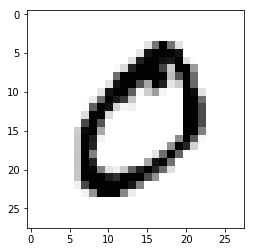

In [7]:
import matplotlib.pyplot as plt

plt.imshow(dataset.train_data[1], interpolation='none', aspect='equal', cmap='Greys')
plt.show()

To actually apply the transformations, we use `dataset.__getitem__()`, i.e.

In [8]:
dataset[1]

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

That is, for each training example it returns a **pair** of (features, label).

Note the type and size of the data after the transformations:

In [9]:
(features, label) = dataset[1]

print("Features size: %s of type: %s" % (features.size(), features.dtype))
print("Label is: %s of type: %s" % (label, label.dtype))

Features size: torch.Size([1, 28, 28]) of type: torch.float32
Label is: tensor(0) of type: torch.int64


You can plot that data, too - so there is actually no need to reach into `dataset.train_data`:

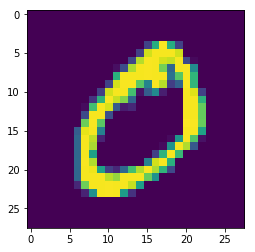

In [10]:
plt.imshow(features[0])
plt.show()

### 1.2 Transforming the data

We can apply the transforms to the raw input data manually, just to see how they work.

Each transform implements the `.__call__()` method that actually transforms the data. Note that this means that the transform can also have a state that cnahges from one input value to the next. (This can be useful e.g. for some sliding window smoothing etc.)

In [11]:
help(transforms.ToTensor)

Help on class ToTensor in module torchvision.transforms.transforms:

class ToTensor(builtins.object)
 |  Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
 |  
 |  Converts a PIL Image or numpy.ndarray (H x W x C) in the range
 |  [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
 |  
 |  Methods defined here:
 |  
 |  __call__(self, pic)
 |      Args:
 |          pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
 |      
 |      Returns:
 |          Tensor: Converted image.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



Note that `dataset.train_data` is a PyTorch tensor, and `ToTensor()` accepts either a PIL image or a numpy array. I guess that the MNIST dataset performs that conversion implicitly (i.e. it uses `torch.tensor` just for storage). Anyway, we have to call `.numpy()` to make things work here.

Also note that transforms work on **batch** data. Here we convert *two* first examples into a `float32` tensor: 

In [12]:
transformed_data = transforms.ToTensor()(dataset.train_data[:2].numpy())

print("Data size after the transformation: %s\n" % str(transformed_data.size()))
print(transformed_data)

Data size after the transformation: torch.Size([28, 2, 28])

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


So each (`unit8`) pixel is converted into a `float32` value of `[0.0 ... 1.0]` range.

(I have no idea why the batch size dimension slips into the middle between image height and width.)

Transforms are composable:

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

transformed_data = transform(dataset.train_data[:2].numpy())

print("Data size after the transformation: %s\n" % str(transformed_data.size()))
print(transformed_data)

Data size after the transformation: torch.Size([28, 2, 28])

tensor([[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]])


So we end up with the same data as we get from `dataset.__getitem__()` (modulo the weird dimensions).

`transforms.Compose()` applies the transforms as they go in the list, i.e. in our example it first invokes `ToTensor`, and then feeds the resulting tensor into `Normalize`.

### 1.3 Other available datasets and transforms

There are many other prepackaged datasets and transforms available in `torchvision`:

In [14]:
datasets.__all__

('LSUN',
 'LSUNClass',
 'ImageFolder',
 'DatasetFolder',
 'FakeData',
 'CocoCaptions',
 'CocoDetection',
 'CIFAR10',
 'CIFAR100',
 'EMNIST',
 'FashionMNIST',
 'MNIST',
 'STL10',
 'SVHN',
 'PhotoTour',
 'SEMEION',
 'Omniglot')

In [15]:
[clazz for clazz in dir(transforms) if clazz[0].isupper()]

['CenterCrop',
 'ColorJitter',
 'Compose',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor']

There's also a bunch of functions defined in `transforms.functional` that can come in handy if you have to write your own image transforms.

#### 1.3.1 Note on PIL performance

By default, `torchvision` uses [Pillow](https://python-pillow.org) package as modern replacement of the good old `PIL` Python Image Manipulation library (see [torchvision image backend](https://github.com/pytorch/vision#image-backend)).

If you have a newer generation Intel or AMD chip, you can instead use a drop-in replacement for `Pillow`, called [Pillow-SIMD](https://github.com/uploadcare/pillow-simd), that can utilize AVX and SSE instructions.

To see what instructions are supported on your PC, in Linux you can look at `/proc/cpuinfo` and check gcc capabilities with `gcc --help=target`. 